# Cuaderno 23: Modelo compacto  para el ATSP

$\newcommand{\card}[1]{\left| #1 \right|}$
$\newcommand{\tabulatedset}[1]{\left\{ #1 \right\}}$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\RR}{\mathbb{R}}$

Dados: 
* un grafo dirigido **completo** $D=(V,A)$, con $V=\{1, \ldots, n\}$; y,
* un vector $c \in \ZZ^{A}$ de costos asociados a los arcos de $D$.

El *problema del agente viajero asimétrico (Asymmetric Traveling Salesman Problem, ATSP)* consiste en encontrar un circuito dirigido que visite **todos** los nodos de $D$ y que tenga el menor costo posible.

Puede evitarse la formación de subciclos introduciendo variables auxiliares de ordenamiento $u_i$ para los nodos $i \in V \setminus \{ 1 \}$, que indiquen la posición del nodo dentro del tour (asumiendo que el nodo 1 ocupa la primera posición). Utilizando además variables binarias $x_{ij}$ para indicar la selección de arcos en el circuito, el problema del agente viajero puede formularse como el siguiente programa lineal entero:

\begin{align*}
\min &\sum_{(i,j) \in A} c_{ij} x_{ij}\\ 
& \mbox{s.r.}\\
&\sum_{(j, i) \in A} x_{ji} = 1, \quad \forall i \in V,\\
&\sum_{(i, j) \in A} x_{ij} = 1, \quad \forall i \in V,\\ 
& u_j \geq u_i + (1 + n) x_{ij} - n, \quad\forall (i,j) \in A, i \neq 1, j \neq 1, \\
& x_{ij} \in \{0, 1\}, \quad \forall (i, j) \in A,\\
& u_i \in \{2, \ldots, n \} \quad \forall i \in V \setminus \{1\}.\\
\end{align*}

Vamos a implementar este modelo usando la interfaz Python de Gurobi.



Definimos primero los datos. Usaremos la función `randint` para generar puntos con coordenadas aleatorias en el rango {0,..,100}. El costo de un arco $(i,j)$ será igual a la distancia euclideana entre $i$ y $j$:

In [2]:
from gurobipy import *
import random as rm
import math 

# Numero de nodos del grafo
n = 50

# Nodos del grafo
V = tuplelist(range(1,n+1))

# Nodos sin el primero
V2 = V[1:]

# Posiciones de los nodos en un plano euclideano entre (0,0) y (100, 100)
coordx={i : rm.randint(0,100) for i in V}
coordy={i : rm.randint(0,100) for i in V}

# los costos son las distancias eculideanas
c = tupledict({
    (i,j) : math.sqrt((coordx[i] - coordx[j])**2 + (coordy[i] - coordy[j])**2)
    for i in V for j in V if i!=j
})
 
A = c.keys()


Emplearemos el módulo `matplotlib` para graficar el tour de la solución. Definiremos para ello la función `dibujarTour` que recibe tres argumentos: una lista `coordx` con las coordenadas horizontales de los nodos, una lista `coordy` con las coordenadas verticales y un vector `tour` con una permutación de los nodos indicando el orden de visita en la solución.

In [3]:
import matplotlib.pyplot as plt
import random

def dibujarTour(coordx, coordy, tour):
    x = [coordx[i] for i in tour]
    y = [coordy[i] for i in tour]
    plt.plot(x, y, 'ro')
    Tx = [coordx[i] for i in tour]
    Ty = [coordy[i] for i in tour]
    Tx.append(coordx[tour[0]])
    Ty.append(coordy[tour[0]])
    plt.plot(Tx, Ty, 'b-')
    plt.show()

Definimos ahora el objeto modelo, las variables y la función objetivo. Notar que las variables de ordenamiento son enteros en el rango $\{2,\ldots, n\}$ y que existe una variable para cada nodo excepto el nodo 1.

In [4]:
# Crear el objeto modelo
m = Model('atsp-compacto')

# Crear las variables de seleccion de arcos
x = m.addVars(A, name="x", vtype=GRB.BINARY)

# Crear las variables de ordenamiento de nodos
u = m.addVars(V2, name="u", vtype=GRB.INTEGER, lb=2, ub=n)

# Crear la funcion objetivo
m.setObjective(x.prod(c,'*'), GRB.MINIMIZE)


Using license file /Users/ltorres/gurobi.lic
Academic license - for non-commercial use only


Añadimos las restricciones de grado:

In [5]:
# Restricciones de grado saliente
m.addConstrs((x.sum(i,'*')  == 1 for i in V), 
                 "g_saliente")
    
# Restricciones de grado entrante
m.addConstrs((x.sum('*', i)  == 1 for i in V), 
                 "g_entrante")

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>,
 22: <gurobi.Constr *Awaiting Model Update*

Para eliminar los subciclos, empleamos las restricciones que fijan valores a las variables de ordenamiento

In [6]:
# Restricciones de ordenamiento de nodos
m.addConstrs((u[j]  >= u[i] + (1 + n)*x[i,j] - n 
              for i,j in A if i!=1 and j!=1), "ordenamiento");

Escribimos el modelo a un archivo de texto:

In [7]:
# Escribir el modelo a un archivo
m.write('tsp.lp')


Establecer un tiempo límite para la solución del modelo y una tolerancia para la brecha de optimalidad:

In [8]:
# Terminar al alcanzar un Gap del 1%
m.Params.MIPGap = 0.01

# Terminar luego de 180 segundos
m.Params.TimeLimit = 180

Changed value of parameter MIPGap to 0.01
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter TimeLimit to 180.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf


Finalmente, resolvemos el modelo y mostramos la solución:

In [9]:
# Calcular la solucion optima
m.optimize()

# Escribir la solucion
if m.status == GRB.Status.OPTIMAL:
    # Recuperar los valores de las variables
    vx = m.getAttr('x', x)
    print('\nTour optimo:')
    for i,j in A:
        if vx[i,j] > 0:
            print('{} -> {}'.format(i, j))


Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2452 rows, 2499 columns and 11956 nonzeros
Model fingerprint: 0xe8dc7537
Variable types: 0 continuous, 2499 integer (2450 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve time: 0.10s
Presolved: 2452 rows, 2499 columns, 11956 nonzeros
Variable types: 0 continuous, 2499 integer (2450 binary)
Found heuristic solution: objective 2819.7806201
Found heuristic solution: objective 2420.9886943

Root relaxation: objective 4.166216e+02, 173 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  416.62161    0   74 2420.98869  416.62161  82.8%     -    0s
     0     0  495.70505    0  121 2420.98869  495.70505  79.5%     -    1s
     0     0  496.47910    0  135

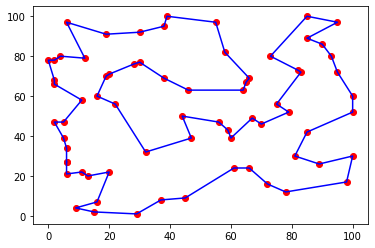

In [12]:
# Crear lista con arcos seleccionados en la solucion
vx = m.getAttr('x', x)
L = [(i,j) for i,j in A if vx[i,j]>=0.95]

# Recuperar el tour como un ordenamiento de los nodos
T = [1]
# nodo actual:
i = 1
while True:
    # Determinar sucesor de i
    j = [j for j in V if (i,j) in L].pop()
    # Colocar sucesor en la lista del tour y actualizar i
    T.append(j)
    i = j
    # Terminar cuando el nodo colocado sea 1
    if i==1: break;
        
# Graficar el tour
dibujarTour(coordx, coordy, T)    

## Código completo

Se reproduce a continuación el código completo del modelo anterior.

In [11]:
# Implementación de modelos lineales enteros
# Modelo compacto para el problema del agente viajero asimétrico (ATSP)

# Luis M. Torres (EPN 2020)

from gurobipy import *
import random as rm
import matplotlib.pyplot as plt

def dibujarTour(coordx, coordy, tour):
    x = [coordx[i] for i in tour]
    y = [coordy[i] for i in tour]
    plt.plot(x, y, 'ro')
    Tx = [coordx[i] for i in tour]
    Ty = [coordy[i] for i in tour]
    Tx.append(coordx[tour[0]])
    Ty.append(coordy[tour[0]])
    plt.plot(Tx, Ty, 'b-')
    plt.show()

# Numero de nodos del grafo
n = 70

# Nodos del grafo
V = tuplelist(range(1,n+1))

# Nodos sin el primero
V2 = V[1:]

# Posiciones de los nodos en un plano euclideano entre (0,0) y (100, 100)
coordx={i : rm.randint(0,100) for i in V}
coordy={i : rm.randint(0,100) for i in V}

# los costos son las distancias eculideanas
c = tupledict({
    (i,j) : math.sqrt((coordx[i] - coordx[j])**2 + (coordy[i] - coordy[j])**2)
    for i in V for j in V if i!=j
})
 
A = c.keys()

try:
    # Crear el objeto modelo
    m = Model('tsp')

    # Crear las variables de seleccion de arcos
    x = m.addVars(A, name="x", vtype=GRB.BINARY)

    # Crear las variables de ordenamiento de nodos
    u = m.addVars(V2, name="u", vtype=GRB.INTEGER, lb=2, ub=n)

    # Crear la funcion objetivo
    m.setObjective(x.prod(c,'*'), GRB.MINIMIZE)

    # Restricciones de grado saliente
    m.addConstrs((x.sum(i,'*')  == 1 for i in V), 
                 "g_saliente")
    
    # Restricciones de grado entrante
    m.addConstrs((x.sum('*', i)  == 1 for i in V), 
                 "g_entrante")

    # Restricciones de ordenamiento de nodos
    m.addConstrs((u[j]  >= u[i] + (1 + n)*x[i,j] - n 
                  for i,j in A if i!=1 and j!=1), "ordenamiento")

    # Escribir el modelo a un archivo
    # m.write('tsp.lp')

    # Terminar al alcanzar un Gap del 1%
    m.Params.MIPGap = 0.01

    # Terminar luego de 180 segundos
    m.Params.TimeLimit = 180    # Calcular la solucion optima

    m.optimize()

    # Escribir la solucion
    if m.status == GRB.Status.OPTIMAL:
        # Recuperar los valores de las variables
        vx = m.getAttr('x', x)
        print('\nTour optimo:')
        for i,j in A:
            if vx[i,j] > 0:
                print('{} -> {}'.format(i, j))
                
    # Crear lista con arcos seleccionados en la solucion
    L = [(i,j) for i,j in A if vx[i,j]>0]

    # Recuperar el tour como un ordenamiento de los nodos
    T = [1]
    # nodo actual:
    i = 1
    while True:
        # Determinar sucesor de i
        j = [j for j in V if (i,j) in L].pop()
        # Colocar sucesor en la lista del tour y actualizar i
        T.append(j)
        i = j
        # Terminar cuando el nodo colocado sea 1
        if i==1: break;
        
    # Graficar el tour
    dibujarTour(coordx, coordy, T)    
    
except GurobiError as e:
    print('Se produjo un error de Gurobi: codigo: ' + str(e.errno) + ": " + str(e))

except AttributeError:
    print('Se produjo un error de atributo')

Changed value of parameter MIPGap to 0.01
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter TimeLimit to 180.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 4832 rows, 4899 columns and 23736 nonzeros
Model fingerprint: 0x7173a13e
Variable types: 0 continuous, 4899 integer (4830 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 7e+01]
Presolve time: 0.16s
Presolved: 4832 rows, 4899 columns, 23736 nonzeros
Variable types: 0 continuous, 4899 integer (4830 binary)

Root relaxation: objective 5.338075e+02, 288 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  533.80750    0  141          -  533.80750      -     -    1s
     0     0  642.

KeyError: (1, 51)